## Building the basic MIMIC feautre matrix for NLD work.

* We take minimum and maximum values of each variable during four hour sample window (four hours prior to callout)
* For 'single_feature_variables' we take only the final value (variables which are infrequently recorded will have the same value for min and max and therefore using both min and max as features for these variables does not make sense).
* We find that there are a lot of missing values when using the four hour sample window. So, where values are missing we look back over an extended sample window of 36 hours and take the final value during that time as the feature value.
* The above procedure results in imbalanced class sizes (there are relatively few patients with negative outcomes following callout). To balance the class sizes we sample from icustays using the same method described above, but at a sample time that is an integer multiple of 24 hours prior to callout (but not within 24 hours of icu admission). We specify that this sample must be taken at least 72 hours prior to callout, under the assumption that a patient is deintitely not ready for discharge at this point in time.
* These extra instances of the negative class are assigned unique identifier and treated as separate patients, however we save the id mapping so we can tell which stay each sample was taken from and at what time point.

#### First we configure this script:

In [1]:
DATA_PATH = 'mimic_all_data_CLEANED'   ## where the data we previously extracted and cleaned up from mimic is stored
SAVE_FLAG = True    ## allows running this script without autmatically overwriting previous feature matrices
HOURS_BEFORE_RFD = 4    ## original sample window (four hours specified by NLD)
MAXIMUM_LOOKBACK = 36   ## extension to sample window when no value recorded in original window (final valule taken)

## variables for which to only use single feature column:
single_feature_variables = ['k', 'na', 'bun', 'creatinine', 'hco3', 'haemoglobin', 'fio2', 'airway', 'pco2', 'po2', 'pain']

In [2]:
import graphlab
import numpy as np
import pickle
import datetime
import shutil
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import graphlab.aggregate as agg
%matplotlib inline

This non-commercial license of GraphLab Create for academic use is assigned to cm1788@bristol.ac.uk and will expire on October 04, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1553272077.log


#### Load the data that we have previously extracted and pre-processed from MIMIC:

In [3]:
all_data = graphlab.SFrame(DATA_PATH)

#### Create an SFrame to store summary of missing data:

In [4]:
missing_data_summary = graphlab.SFrame()

#### Select only measurments taken in HOURS_BEFORE_DISCHARGE:

In [5]:
all_data = all_data[all_data['hrs_bRFD']<=HOURS_BEFORE_RFD]
all_data = all_data[all_data['hrs_bRFD']>=0]
print "There are %d icu satys with variables recorded in the final %d hours before CALLOUT." %(len(all_data['C.ICUSTAY_ID'].unique()),HOURS_BEFORE_RFD)

There are 11267 icu satys with variables recorded in the final 4 hours before CALLOUT.


#### Produce data summary:

In [6]:
summary = all_data.groupby(key_columns=['C.ICUSTAY_ID'], operations={'outcome':agg.SELECT_ONE('outcome'),
                                                                     'cohort':agg.SELECT_ONE('cohort'),
                                                                     'readmit':agg.SELECT_ONE('readmit'),
                                                                     'in_h_death':agg.SELECT_ONE('in_h_death'),
                                                                     'in_icu_death':agg.SELECT_ONE('in_icu_death'),
                                                                     'II.LOS':agg.SELECT_ONE('II.LOS'),
                                                                     'II.OUTTIME':agg.SELECT_ONE('II.OUTTIME'),
                                                                     'II.INTIME':agg.SELECT_ONE('II.INTIME')
                                                                    })

print "There are %d icu stays in the cohort." %sum(summary['cohort']==1)
cohort_summary = summary[summary['cohort']==1]

There are 10650 icu stays in the cohort.


#### We now begin to construct the feature matrix.

In [7]:
features = all_data.groupby(key_columns=['C.ICUSTAY_ID', 'VARIABLE'], 
                            operations={'min':agg.MIN('C.VALUENUM'),
                                        'max':agg.MAX('C.VALUENUM'),
                                        'values':agg.CONCAT('C.VALUENUM'),
                                        'count':agg.COUNT('C.VALUENUM'),
                                        'cohort':agg.SELECT_ONE('cohort'),
                                        'outcome':agg.SELECT_ONE('outcome')
                                        })

features = features.sort(ascending=True, sort_columns='C.ICUSTAY_ID')

#### We define a function that takes the above dataframe and splits it into feature columns:

In [8]:
def _split_features_to_columns(features, single_feature_vars=single_feature_variables):
    ''' Note: sort features by ICUSTAY_ID before using this function.'''
    
    all_variables = features['VARIABLE'].unique()
    all_stay_ids = features['C.ICUSTAY_ID'].unique().sort()
    
    thisFM = graphlab.SFrame()
    thisFM['ICUSTAY_ID'] = all_stay_ids
    
    for var in all_variables:
        print var

        var_min = []
        var_max = []
        var_values = []
        var_count = []

        _subset = features[features['VARIABLE']==var]
        N = len(_subset)-1

        rid = 0
        for sid in all_stay_ids:
            if rid<=N and _subset[rid]['C.ICUSTAY_ID']==sid:
                ## add data and move on a row
                row = _subset[rid]
                var_min.append(row['min'])
                var_max.append(row['max'])
                var_values.append(row['values'])
                rid += 1
            else:
                ## add None values and stay in place
                var_min.append(None)
                var_max.append(None)
                var_values.append([])

        if var not in single_feature_vars:
            thisFM[var + '_min'] = var_min
            thisFM[var + '_max'] = var_max
    
        else:
            ## if it is a single variable feature - take final value only
            thisFM[var] = [val[-1]  if len(val)>0 else None for val in var_values]
        
    return thisFM

In [9]:
FM = _split_features_to_columns(features, single_feature_variables)

creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na


#### How many missing values are there in this feature matrix?

In [10]:
nrows = float(len(FM))

missing_data = graphlab.SFrame()
vname = []
miss_freq = []

for col in FM.column_names():
    vname.append(col) 
    miss_freq.append(sum(FM[col]==None)/nrows)
        
missing_data['variable'] = vname
missing_data['fraction missing'] = miss_freq

missing_data = missing_data.sort('fraction missing', ascending=True)
missing_data.print_rows(num_rows=25)

+-------------+------------------+
|   variable  | fraction missing |
+-------------+------------------+
|  ICUSTAY_ID |       0.0        |
|    hr_max   | 0.00168634064081 |
|    hr_min   | 0.00168634064081 |
|   resp_min  | 0.00603532439869 |
|   resp_max  | 0.00603532439869 |
|    bp_min   | 0.00665660779267 |
|    bp_max   | 0.00665660779267 |
|   spo2_min  | 0.0113606106328  |
|   spo2_max  | 0.0113606106328  |
|   temp_max  | 0.0769503860833  |
|   temp_min  | 0.0769503860833  |
|   gcs_min   |   0.1076595367   |
|   gcs_max   |   0.1076595367   |
|     pain    |  0.461258542647  |
|      k      |  0.874589509186  |
|      na     |  0.874678263957  |
|     bun     |  0.883731250555  |
|  creatinine |  0.883997514866  |
|     hco3    |  0.88453004349   |
| haemoglobin |  0.894293068252  |
|     fio2    |  0.932102600515  |
|    airway   |  0.984911689003  |
|     pco2    |  0.987663086891  |
|     po2     |  0.987663086891  |
+-------------+------------------+
[24 rows x 2 columns

#### Some variables have a very high frequency of missing values. We decided to improve this by relaxing the 4 hour measurement window of the NLD criteria - SEE BLEOW. In some cases (e.g. laboratory results) this is clearly too short a window and is producing lots of missingness. 

In [11]:
missing_data_summary['variable'] = missing_data['variable']
missing_data_summary = missing_data_summary.join(how='inner',on='variable',right=missing_data)
missing_data_summary = missing_data_summary.rename({'fraction missing':'mimic_4hr'})

#### Here we fill airway since absence -> no ETT at this time and therefore patent airway:

In [12]:
FM_filled = FM.copy()
FM_filled = FM_filled.fillna(column='airway', value=0.0)

#### We construct a table with the final value before CALLOUT for each variable for each stay:

In [13]:
all_data = graphlab.SFrame(DATA_PATH)
all_data = all_data[all_data['hrs_bRFD']>=0]
all_data = all_data.filter_by(column_name='C.ICUSTAY_ID', values=FM_filled['ICUSTAY_ID'])

In [14]:
final_values = all_data.groupby(key_columns=['C.ICUSTAY_ID', 'VARIABLE'], 
                                operations={
                                            'hrs_bRFD':agg.ARGMAX('C.CHARTTIME', 'hrs_bRFD'),
                                            'C.VALUENUM':agg.ARGMAX('C.CHARTTIME', 'C.VALUENUM')
                                            })

final_values = final_values[final_values['hrs_bRFD']<=MAXIMUM_LOOKBACK]
final_values = final_values[final_values['hrs_bRFD']>HOURS_BEFORE_RFD]
final_values = final_values.sort(ascending=True, sort_columns=['VARIABLE', 'C.ICUSTAY_ID'])

In [15]:
vars_to_use_fv = [var for var in final_values['VARIABLE'].unique()]

In [16]:
FM_filled = FM_filled.sort(ascending=True, sort_columns='ICUSTAY_ID')

#### We now replace missing values (from four hour window) with final values from the extended window (where available):

In [17]:
def replace_missing_value(subset, variable, FM_filled, N, vtype='min'):
    
    if vtype=='min':
        suffix = '_min'
    elif vtype=='max':
        suffix = '_max'
    elif vtype=='single':
        suffix = ''
        
    new_col = []
    _subset_row_counter = 0
    
    for iid,val in zip(FM_filled['ICUSTAY_ID'], FM_filled[variable+suffix]):

        if val==None:
            if _subset_row_counter<=N and subset[_subset_row_counter]['C.ICUSTAY_ID']==iid:
                new_col.append(subset[_subset_row_counter]['C.VALUENUM'])
                _subset_row_counter += 1
            else:
                new_col.append(None)
        else:
            new_col.append(val)

    FM_filled[variable+suffix] = new_col
    return FM_filled


for variable in vars_to_use_fv:
    print variable
    _subset = final_values[final_values['VARIABLE']==variable]
    _subset = _subset.sort(sort_columns='C.ICUSTAY_ID', ascending=True)
    N = len(_subset)-1
    
    if variable not in single_feature_variables:
        FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='min')
        FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='max')
    
    else:
        FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='single')

creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na


#### We see that this has improved the missingness for most variables:

In [18]:
nrows = float(len(FM_filled))
for col in FM_filled.column_names():
    print '%s : %.3f' %(col, sum(FM_filled[col]==None)/nrows)

ICUSTAY_ID : 0.000
creatinine : 0.019
po2 : 0.783
fio2 : 0.686
pco2 : 0.782
bp_min : 0.000
bp_max : 0.000
pain : 0.140
k : 0.017
hr_min : 0.000
hr_max : 0.000
gcs_min : 0.003
gcs_max : 0.003
bun : 0.019
hco3 : 0.019
airway : 0.000
resp_min : 0.001
resp_max : 0.001
haemoglobin : 0.024
spo2_min : 0.001
spo2_max : 0.001
temp_min : 0.002
temp_max : 0.002
na : 0.017


In [19]:
missing_data_summary['mimic_36hr'] = missing_data_summary.apply(lambda row: sum(FM_filled[row['variable']]==None)/nrows if row['variable']!='ICUSTAY' else 0.0) 

In [20]:
_sum_sub = summary['C.ICUSTAY_ID', 'cohort', 'outcome']
_sum_sub = _sum_sub.rename(names={'C.ICUSTAY_ID':'ICUSTAY_ID'})
FM_filled = FM_filled.join(how='inner', on='ICUSTAY_ID', right=_sum_sub)

#### We now have a feature matrix. However, the class sizes are highly imbalanced. We decided to balance the class sizes by creating more instances of the negative class. We do this by sampling the patients at integer multiples of 24 hours prior to their CALLOUT.

In [21]:
all_data = graphlab.SFrame(DATA_PATH)

We look at how many stays are available at Xi days prior to callout, and how many extra samples would be required to balance the class sizes:

In [22]:
_stay_summary = all_data.groupby(key_columns='C.ICUSTAY_ID',operations={'outcome':agg.SELECT_ONE('outcome'), 'RFD':agg.SELECT_ONE('RFD'), 'intime':agg.SELECT_ONE('II.INTIME')})
_stay_summary['len'] = (_stay_summary['RFD'] - _stay_summary['intime'])/(60*60)

In [23]:
fx = lambda x:24*x + 4

In [24]:
_stays = []
for i in range(10):
    _stays.append(sum(_stay_summary['len'] >= fx(i)))

In [25]:
num_rfd0 = sum(FM_filled['outcome'])
num_nrfd0 = len(FM_filled['outcome']) - num_rfd0

print num_rfd0
print num_nrfd0
print "We would need at least %d extra samples to balance the classes." %(num_rfd0 - num_nrfd0)

9639
1628
We would need at least 8011 extra samples to balance the classes.


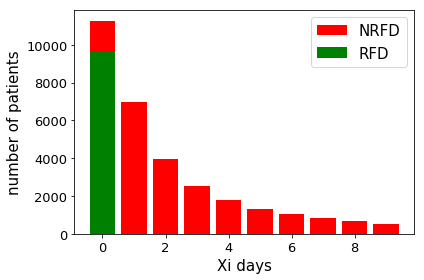

In [26]:
fsa = 15

plt.bar(range(10), _stays, color='r', label='NRFD')
ax = plt.gca()
ax.bar(0,num_rfd0, color='g', label='RFD')
plt.legend(fontsize=fsa)
plt.xlabel('Xi days', fontsize=fsa)
plt.ylabel('number of patients', fontsize=fsa)
plt.xticks(fontsize=fsa-2)
plt.yticks(fontsize=fsa-2)

plt.tight_layout()
plt.savefig('mimic_negex_bars.png')

#### We determine that sampling at Xi in (3-8) will provide more than enough extra NRFD instances.

In [27]:
def sample_at_xi(_all_data, _summary, xi=3, h=4):
    ## selects stays to include in negative extras
    ## xi is integer number of days before RFD flag
    ## h is sample window length (4 hours is NLD standard)
    ##      new: only stays that are at least (xi+1)*24 hours long are included
    ##           so that sample point does not fall within 24 hours of ICU admission (thanks to reviewer 2) 
    
    sids = _summary[_summary['len']>= fx(xi + 1)]['C.ICUSTAY_ID']  ## added +1 to filter out sample points that would be witin 24 hours of admission to ICU
    sub_data = _all_data.filter_by(column_name='C.ICUSTAY_ID',values=sids, exclude=False)
    
    sub_data = sub_data[sub_data['hrs_bRFD']>= 24*xi]
    sub_data = sub_data[sub_data['hrs_bRFD']<= 24*xi + h]
    return sub_data

In [28]:
Xi_range = [3,4,5,6,7,8]
H = 4
fx = lambda x:24*x + H

for Xi in Xi_range:
    
    sub_data = sample_at_xi(all_data, _stay_summary, Xi, H)
    print "Xi = %d, ns = %d" %(Xi, len(sub_data['C.ICUSTAY_ID'].unique()))

Xi = 3, ns = 1774
Xi = 4, ns = 1315
Xi = 5, ns = 1033
Xi = 6, ns = 844
Xi = 7, ns = 674
Xi = 8, ns = 537


In [29]:
print "The lowest ICUSTAY_ID in the dataset is: %d." %min(all_data['C.ICUSTAY_ID'])

The lowest ICUSTAY_ID in the dataset is: 200001.


#### We create a one-to-one ID mapping so we can unqileuy identify which patient each new sample comes from:

In [30]:
id_mapping = graphlab.SFrame()
largest_id = max(all_data['C.ICUSTAY_ID'])

for Xi in Xi_range:
    sub_data = sample_at_xi(all_data, _stay_summary, Xi, H)
    
    L = len(sub_data['C.ICUSTAY_ID'].unique())
    _temp_id_mapping = graphlab.SFrame()
    _temp_id_mapping['Xi'] = Xi * np.ones(L)
    _temp_id_mapping['ICUSTAY_ID'] = sub_data['C.ICUSTAY_ID'].unique()
    id_mapping = id_mapping.append(_temp_id_mapping)

id_mapping['new_ID'] = np.arange(len(id_mapping))

In [31]:
if SAVE_FLAG:
    id_mapping.save('mimic_negative_extras_id_mapping')

#### Get features for the new samples at Xi = [3,4,5,6,7,8]:

In [32]:
def get_Xi_features(Xi, all_data, _stay_summary, id_mapping, H=4):
    
    sub_data = sample_at_xi(all_data, _stay_summary, Xi, H)
    ## now get features from subset of data:
    features = sub_data.groupby(key_columns=['C.ICUSTAY_ID', 'VARIABLE'], 
                                operations={'min':agg.MIN('C.VALUENUM'),
                                            'max':agg.MAX('C.VALUENUM'),
                                            'mean':agg.MEAN('C.VALUENUM'),
                                            'var':agg.VARIANCE('C.VALUENUM'),
                                            'times':agg.CONCAT('C.CHARTTIME'),
                                            'values':agg.CONCAT('C.VALUENUM'),
                                            'count':agg.COUNT('C.VALUENUM'),
                                            'cohort':agg.SELECT_ONE('cohort'),
                                            'outcome':agg.SELECT_ONE('outcome')
                                            })

    ids = id_mapping.filter_by(column_name='Xi', values=float(Xi))
    features = features.rename({'C.ICUSTAY_ID': 'ICUSTAY_ID'})
    features = features.join(right=ids, on='ICUSTAY_ID', how='inner')

    features = features.remove_column('ICUSTAY_ID')
    features = features.rename({'new_ID': 'C.ICUSTAY_ID'})

    features = features.sort(ascending=True, sort_columns='C.ICUSTAY_ID')

    _temp_FM = _split_features_to_columns(features)
    return _temp_FM


In [33]:
_FM_negative = get_Xi_features(Xi_range[0], all_data, _stay_summary, id_mapping)

for Xi in Xi_range[1:]:
    print Xi
    _temp_FM = get_Xi_features(Xi, all_data, _stay_summary, id_mapping)
    _FM_negative = _FM_negative.append(_temp_FM)

creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
4
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
5
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
6
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
7
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
8
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na


#### How much missing data?

In [34]:
nrows = float(len(_FM_negative))

missing_data = graphlab.SFrame()
vname = []
miss_freq = []

for col in _FM_negative.column_names():
        vname.append(col)
        miss_freq.append(sum(_FM_negative[col]==None)/nrows)
        
missing_data['variable'] = vname
missing_data['fraction missing'] = miss_freq

missing_data = missing_data.sort('fraction missing', ascending=True)
missing_data.print_rows(num_rows=25)

+-------------+------------------+
|   variable  | fraction missing |
+-------------+------------------+
|  ICUSTAY_ID |       0.0        |
|    hr_max   | 0.00178079974097 |
|    hr_min   | 0.00178079974097 |
|    bp_min   | 0.00291403593978 |
|    bp_max   | 0.00291403593978 |
|   spo2_min  | 0.00404727213858 |
|   spo2_max  | 0.00404727213858 |
|   resp_max  | 0.00453294479521 |
|   resp_min  | 0.00453294479521 |
|   temp_max  | 0.0715557714101  |
|   temp_min  | 0.0715557714101  |
|   gcs_min   | 0.0762506070908  |
|   gcs_max   | 0.0762506070908  |
|     fio2    |  0.331714424478  |
|    airway   |  0.462198478226  |
|     pain    |  0.462198478226  |
|     po2     |  0.805569046463  |
|     pco2    |  0.805569046463  |
|      k      |  0.841508823053  |
|      na     |  0.854621984782  |
|     hco3    |  0.877610490529  |
|  creatinine |  0.886352598349  |
|     bun     |  0.886838271005  |
| haemoglobin |  0.909502994981  |
+-------------+------------------+
[24 rows x 2 columns

In [35]:
missing_data_summary = missing_data_summary.join(how='inner', on='variable', right=missing_data)
missing_data_summary = missing_data_summary.rename({'fraction missing':'mimic_negex_4hour'})

#### Fill the missing data:

In [36]:
_FM_negative_filled = _FM_negative.copy()
_FM_negative_filled = _FM_negative_filled.fillna(column='airway', value=0.0)

In [37]:
def fill_with_final_values(FM_filled, Xi, new_icustays):
    
    all_data = graphlab.SFrame(DATA_PATH)
    all_data = all_data[all_data['hrs_bRFD'] >= 24*Xi]
    
    new_icustays = new_icustays.rename({'ICUSTAY_ID':'C.ICUSTAY_ID'})
    all_data = all_data.join(right=new_icustays, on='C.ICUSTAY_ID', how='inner')
    all_data = all_data.remove_column('C.ICUSTAY_ID')
    all_data = all_data.rename({'new_ID':'C.ICUSTAY_ID'})
    
    final_values = all_data.groupby(key_columns=['C.ICUSTAY_ID', 'VARIABLE'], 
                                    operations={
                                                'hrs_bRFD':agg.ARGMAX('C.CHARTTIME', 'hrs_bRFD'),
                                                'C.VALUENUM':agg.ARGMAX('C.CHARTTIME', 'C.VALUENUM')
                                                })

    final_values = final_values[final_values['hrs_bRFD'] <= MAXIMUM_LOOKBACK + (24*Xi)]
    final_values = final_values[final_values['hrs_bRFD'] > H + (24*Xi)]
    
    final_values = final_values.sort(ascending=True, sort_columns=['VARIABLE', 'C.ICUSTAY_ID'])
    vars_to_use_fv = [var for var in final_values['VARIABLE'].unique()] 
    FM_filled = FM_filled.sort(ascending=True, sort_columns='ICUSTAY_ID')
    
    for variable in vars_to_use_fv:
        print variable

        _subset = final_values[final_values['VARIABLE']==variable]
        _subset = _subset.sort(sort_columns='C.ICUSTAY_ID', ascending=True)
        N = len(_subset)-1
        
        if variable not in single_feature_variables:
            FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='min')
            FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='max')
        else:
            FM_filled = replace_missing_value(_subset, variable, FM_filled, N, vtype='single')
 
    return FM_filled

#### Fill separately for each Xi and then recombine:

In [38]:
Xi = Xi_range[0]
## filter feature matrix to only contain instances from Xi sample
_temp_FM_filled = _FM_negative_filled.filter_by(column_name='ICUSTAY_ID', values=id_mapping[id_mapping['Xi']==float(Xi)]['new_ID'])
## fill with appropriate final values:
new_icustays = id_mapping[id_mapping['Xi']==float(Xi)]
_temp_FM_filled = fill_with_final_values(FM_filled=_temp_FM_filled, Xi=Xi, new_icustays = new_icustays)
FM_negative_filled = _temp_FM_filled.copy()

for Xi in Xi_range[1:]:
    
    ## filter feature matrix to only contain instances from Xi sample
    _temp_FM_filled = _FM_negative_filled.filter_by(column_name='ICUSTAY_ID', values=id_mapping[id_mapping['Xi']==float(Xi)]['new_ID'])
    ## fill with appropriate final values:
    new_icustays = id_mapping[id_mapping['Xi']==float(Xi)]
    _temp_FM_filled = fill_with_final_values(FM_filled=_temp_FM_filled, Xi=Xi, new_icustays = new_icustays)
    FM_negative_filled = FM_negative_filled.append(_temp_FM_filled) 

creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
creatinine
po2
fio2
pco2
bp
pain
k
hr
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na
creatinine
po2
fio2
pco2
pain
k
gcs
bun
hco3
airway
resp
haemoglobin
spo2
temp
na


#### How much missing data in the feature matrix for these extra NRFD samples:

In [39]:
nrows = float(len(FM_negative_filled))
for col in FM_negative_filled.column_names():
        print '%s : %.3f' %(col, sum(FM_negative_filled[col]==None)/nrows)

ICUSTAY_ID : 0.000
creatinine : 0.004
po2 : 0.349
fio2 : 0.203
pco2 : 0.348
bp_min : 0.001
bp_max : 0.001
pain : 0.116
k : 0.004
hr_min : 0.000
hr_max : 0.000
gcs_min : 0.002
gcs_max : 0.002
bun : 0.004
hco3 : 0.004
airway : 0.000
resp_min : 0.002
resp_max : 0.002
haemoglobin : 0.005
spo2_min : 0.002
spo2_max : 0.002
temp_min : 0.021
temp_max : 0.021
na : 0.004


In [40]:
missing_data_summary['mimic_negex_36hr'] = missing_data_summary.apply(lambda row: sum(FM_negative_filled[row['variable']]==None)/nrows ) 

In [41]:
all_data = graphlab.SFrame(DATA_PATH)
summary = all_data.groupby(key_columns=['C.ICUSTAY_ID'], operations={'outcome':agg.SELECT_ONE('outcome'),
                                                                     'cohort':agg.SELECT_ONE('cohort'),
                                                                     'readmit':agg.SELECT_ONE('readmit'),
                                                                     'in_h_death':agg.SELECT_ONE('in_h_death'),
                                                                     'in_icu_death':agg.SELECT_ONE('in_icu_death'),
                                                                     'II.LOS':agg.SELECT_ONE('II.LOS'),
                                                                     'II.OUTTIME':agg.SELECT_ONE('II.OUTTIME'),
                                                                     'II.INTIME':agg.SELECT_ONE('II.INTIME'),
                                                                     'RFD':agg.SELECT_ONE('RFD')
                                                                    })

summary = summary.rename({'C.ICUSTAY_ID':'ICUSTAY_ID'})
cohort_info = id_mapping.join(how='inner', on='ICUSTAY_ID', right=summary)
cohort_info = cohort_info['new_ID', 'cohort']
cohort_info = cohort_info.rename({'new_ID':'ICUSTAY_ID'})

FM_negative_filled = FM_negative_filled.join(how='inner', on='ICUSTAY_ID', right=cohort_info)
FM_negative_filled['outcome'] = np.zeros(len(FM_negative_filled), dtype=int)

#### We finally join the extra negative instances to the original feature matrix: 

In [42]:
FM_filled = FM_filled.append(FM_negative_filled)

#### Save the feature matrix with and without missing values included:

In [43]:
if SAVE_FLAG:
        FM_filled.save('Feature_Matrix_MIMIC_with_missing_values')
        FM_filled_cc = FM_filled.dropna(how='any')
        FM_filled.save('Feature_Matrix_MIMIC_complete_case')

#### Produce summary of missing values as recorded throughout this script:

In [44]:
order = graphlab.SFrame()
order['variable'] =['hr_max', 'hr_min','spo2_max',
                'spo2_min','airway','resp_max',
                'resp_min','bp_min','bp_max',
                'temp_min','temp_max','gcs_max',
                'gcs_min','pain','hco3',
                'pco2','po2','fio2',
                'haemoglobin','k','bun',
                'creatinine','na']

order['num'] = range(len(order))

In [45]:
missing_data_summary = missing_data_summary.join(how='inner', on='variable', right=order)
missing_data_summary = missing_data_summary.sort('num')
missing_data_summary = missing_data_summary.remove_column('num')

In [46]:
missing_data_summary.export_csv(header=True, filename='missing_data_summary_mimic.csv')
missing_data_summary.print_rows(num_rows=len(missing_data_summary))

+-------------+------------------+-------------------+-------------------+
|   variable  |    mimic_4hr     |     mimic_36hr    | mimic_negex_4hour |
+-------------+------------------+-------------------+-------------------+
|    hr_max   | 0.00168634064081 | 0.000355019082276 |  0.00178079974097 |
|    hr_min   | 0.00168634064081 | 0.000355019082276 |  0.00178079974097 |
|   spo2_max  | 0.0113606106328  |  0.00079879293512 |  0.00404727213858 |
|   spo2_min  | 0.0113606106328  |  0.00079879293512 |  0.00404727213858 |
|    airway   |  0.984911689003  |        0.0        |   0.462198478226  |
|   resp_max  | 0.00603532439869 |  0.00106505724683 |  0.00453294479521 |
|   resp_min  | 0.00603532439869 |  0.00106505724683 |  0.00453294479521 |
|    bp_min   | 0.00665660779267 | 0.000443773852845 |  0.00291403593978 |
|    bp_max   | 0.00665660779267 | 0.000443773852845 |  0.00291403593978 |
|   temp_min  | 0.0769503860833  |  0.00213011449365 |  0.0715557714101  |
|   temp_max  | 0.0769503

In [47]:
FM_filled.export_csv('Feature_Matrix_MIMIC_with_missing_values.csv')

In [48]:
FM_filled_cc.export_csv('Feature_Matrix_MIMIC_complete_case.csv')